## [E15] 다양한 OCR모델 비교하기 - 와이파이 비밀번호 OCR
 
 "OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?" 라는 루브릭 평가가 있어서 기획을 생각해보았다. 
 
 #### 기획: 와이파이 비밀번호 자동으로 입력하는 프로그램 만들기
 
- OCR을 적용할 프로젝트를 만들기 위해서 핸드폰에 문자인식에 적합한 이미지가 뭐가 있을까 사진을 살펴보는데 카페등 가게에서 와이파이 연결을 하기 위해서 찍은 사진이 많이 남아있는 것을 확인했다. 생각해보면 가게에서는 손님이 와이파이를 쓰도록 __벽면에 와이파이 비밀번호를 적은 종이를 붙여서__ 와이파이를 제공한다. 즉 광학적인 방법으로 문자 인식을 하면 간단하게 정보를 얻는 것이 가능하다.

- 보통 와이파이 비밀번호의 길이는 8자 이상인 경우가 많았던 것 같아서 입력하는게 수고롭다는 생각이 들었다. 사람들이 손쉽게 입력하라고 일부러 1234~로 기억하기 쉽게 적어놓는 경우가 많기는 하지만, 때때로 복잡한 비밀번호를 저장해두어서 입력하다가 틀리기 쉬웠던 기억이 났다. 그래서 핸드폰 타이핑을 쳐서 직접 입력하는 것보다 __사진만 찍으면 바로 비밀번호를 입력하게 만들면 쉽게 와이파이를 사용할 것 같은 생각__ 이 들었다. 

In [1]:
import os
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt


# 한국어 폰트 설치를 확인합니다.  
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

In [2]:
path=os.getenv('HOME')+'/aiffel/ocr_python/img/'
img=os.listdir(path)
img=[i for i in img if i[0]!="."] # .으로 시작하는 파일은 숨긴 폴더이므로 이미지 파일 리스트에서 제외

In [3]:
print(len(img))

20


In [4]:
# 각 이미지별 파일
imgs={"front":[i for i in img if i.split("_")[0]=="front"], 
      "full":[i for i in img if i.split("_")[0]=="full"],
      "side":[i for i in img if i.split("_")[0]=="side"]}
print(len(imgs["front"]), len(imgs["full"]), len(imgs["side"]))

10 5 4


## 테스트 데이터 특징 

큰틀에서는 사진을 어떤 사이즈의 어떤 각도로 찍었느냐에 차이를 두었다. 그래서    
__1. 정면 이미지(10):__ 와이파이 비밀번호를 정면에서 찍었고 가급적 뒷 배경이 적게 나오는 이미지    
__2. 옆면 이미지(4):__ 와이파이 비밀번호를 측면에서 촬영해서 문자가 기울어지게 촬영되는 이미지    
__3. 전체 이미지(4):__ 뒷배경이 많이 나오는 이미지     

----------------------------------------------------
- 이렇게 3가지로 나누어서 촬영한 이미지를 수집했다. 보통은 와이파이 비밀번호를 적은 종이 앞으로 가서 사진을 찍기 때문에 정면이미지를 가장 다양하고 많이 수집을 했다. 옆면 이미지와 전체 이미지는 __혹시라도 의자에 앉아서 귀찮아서 멀리에 있는 와이파이 안내판을 그냥 사진으로 찍는 경우가 있지 않을까?__ 생각이 들어서 측면 혹은 멀리에서 안내판을 찍은 이미지를 촬영해보았다.

- 그리고 각 이미지들에 손글씨를 포함하였다. 컴퓨터로 출력한 글씨체는 어느정도 일관성 있는 글씨라는 생각이 들어서 인식을 잘 할 것이라 예상 되었기에 손글씨로 입력한 이미지도 인식을 잘하는지 체크해보고 싶었다.

### 정면 원본 이미지

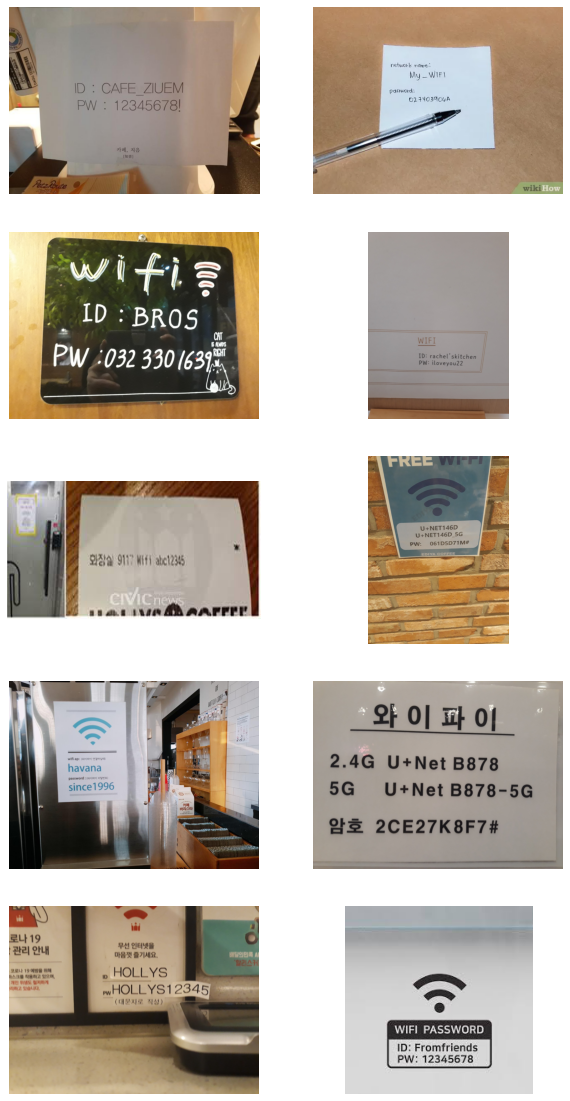

In [5]:
plt.figure(figsize=(10, 20))
for i,j in enumerate(imgs["front"]):
    plt.subplot(5,2,i+1)
    im=Image.open(path+j).convert('RGB')
    plt.imshow(im)
    plt.axis("off")
plt.show()

### 옆면 원본 이미지

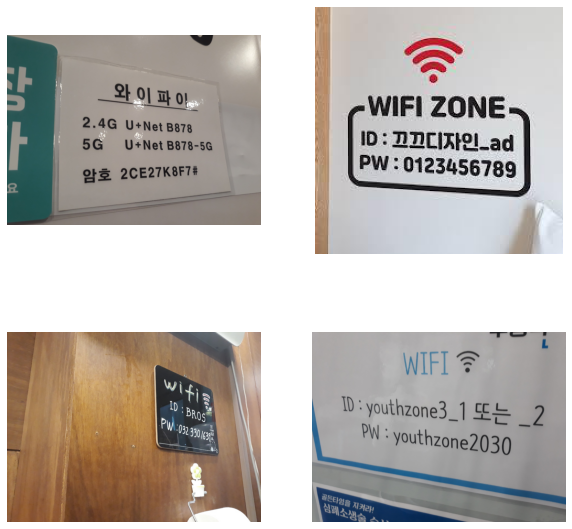

In [6]:
plt.figure(figsize=(10, 10))
for i,j in enumerate(imgs["side"]):
    plt.subplot(2,2,i+1)
    im=Image.open(path+j).convert('RGB')
    plt.imshow(im)
    plt.axis("off")
plt.show()

### 전체 원본 이미지

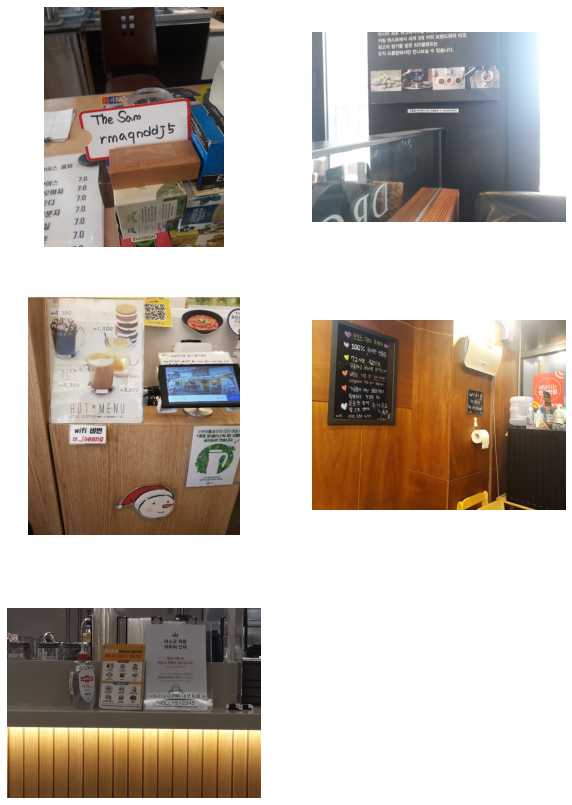

In [7]:
plt.figure(figsize=(10, 15))
for i,j in enumerate(imgs["full"]):
    plt.subplot(3,2,i+1)
    im=Image.open(path+j).convert('RGB')
    plt.imshow(im)
    plt.axis("off")
plt.show()

### Google vision - OCR API

In [8]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()        
        # 이미지를 바이너리 형식으로 불러와서 content에 할당
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    vertices_=[]
    for text in texts:
        #print('\n"{}"'.format(text.description))        
        vertices = ([(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])
        vertices_.append(vertices)

    #print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return image, response, texts, vertices_

In [9]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key_sun.json'

total 2544
drwxr-xr-x 2 root root    4096 Mar  3 00:01  crop
-rw-r--r-- 1 root root   98299 Mar  3 03:39  crop_img.JPG
-rw-r--r-- 1 root root 2488066 Mar  3 04:07 '[E15]OCR.ipynb'
drwxr-xr-x 4 root root    4096 Mar  2 23:12  img
-rw-r--r-- 1 root root    2340 Mar  2 08:21  my_google_api_key_sun.json
drwxr-xr-x 2 root root    4096 Mar  2 23:11  work


### keras OCR API

In [10]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


### 텍서랙트 API

In [11]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    points=[]
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
            points.append({"left":left, "top":top,"right":left+width, "bottom":top+height})
    return cropped_image_path_list, points

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text=[]
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT)
        text.append(recognized_data["text"].replace("\x0c","").replace("\n",""))
    print("Done")
    return text



In [12]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/img/work/'


In [59]:
def display_img(path_,real,fontsize=1,fig_size=(15,10)):
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=fig_size)
    
    # KERAS OCR
    images=keras_ocr.tools.read(path_)
    prediction_groups=pipeline.recognize([path_])
    keras_ocr.tools.drawAnnotations(image=images, predictions=prediction_groups[0], ax=axs[1])

    # Google vision OCR

    img, response, texts, vertices=detect_text(path_)
    im=cv2.imread(path_)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    G_ocr=[]
    for idx in range(len(vertices)):
        im=cv2.rectangle(im,vertices[idx][0],vertices[idx][2],color=(0,0,255))
        im=cv2.putText(img=im, # 이미지
                       text=texts[idx].description, # 입력할 글자
                       org=(vertices[idx][2][0]-10,vertices[idx][2][1]), # 입력할 위치
                       fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                       fontScale=fontsize, color=(255,255,0),thickness=3)
        G_ocr.append(texts[idx].description)
        
    axs[0].imshow(im)
    plt.title("구글비전 OCR %s"%real)
    axs[0].axis("off")

    # 테서렉트 OCR
    img_file_path =  path_    
    cropped_image_path_list,points = crop_word_regions(img_file_path, work_dir)

    # 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
    tr_text=recognize_images(cropped_image_path_list)

    im_1=cv2.imread(path_)
    im_1=cv2.cvtColor(im_1, cv2.COLOR_BGR2RGB)
    
    T_ocr=[]
    for n in range(len(tr_text)):
        j=tr_text[n]
        point=points[n]
        im_1=cv2.rectangle(im_1,(point["left"],point["top"]),(point["right"],point["bottom"]),color=(0,0,255))
        im_1=cv2.putText(img=im_1, # 이미지
                         text=j, # 입력할 글자
                         org=(point["left"],point["bottom"]+30), # 입력할 위치
                         fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                         fontScale=fontsize, color=(255,255,0),thickness=3)
        T_ocr.append(j)
        

        
    axs[2].imshow(im_1)
    plt.title("테서렉트 OCR - %s"%real)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    print("구글OCR:", G_ocr, "/테서렉트OCR:",T_ocr,"/ 이미지 사이즈:",im_1.shape)


In [24]:
front_paths = glob.glob(os.getenv('HOME')+'/aiffel/ocr_python/img/front_*.jpg')
full_paths = glob.glob(os.getenv('HOME')+'/aiffel/ocr_python/img/full_*.jpg')
side_paths=glob.glob(os.getenv('HOME')+'/aiffel/ocr_python/img/side_*.jpg')

## 이미지 OCR 테스트
- 가장 왼쪽이 Google vision- OCR API(이하 구글비전 OCR), 가운데 이미지가 Keras OCR API(이하 케라스 OCR), 오른쪽 이미지가 tesseract API(테서렉트 OCR)이다.

- 정면 이미지 테스트: 정면에서 문자에 최대한 가깝게 찍은 이미지

Done


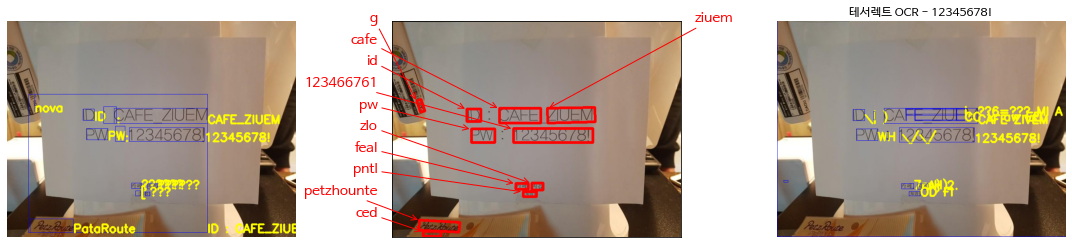

구글OCR: ['ID : CAFE_ZIUEM\nPW : 12345678!\n카페, 지음\n[如\nPataRoute\nnova\n', 'ID', ':', 'CAFE_ZIUEM', 'PW', ':', '12345678!', '카페', ',', '지음', '[', '如', 'PataRoute', 'nova'] /테서렉트OCR: ['', 'i, «6=— MI A RR', '\\| )', '', 'CAFE ZIVEM', 'WH \\/\\/', '', '12345678!', '', '7roH)', 'A} 2.', 'OD Fi', '', '', '', 'CC lc aw EE', '\\ | Pa a |']


In [25]:
display_img(front_paths[0],front_real[0],fontsize=1)

- 전체 이미지 테스트: 정면 혹은 옆에서 배경이 많이 보이도록 찍은 이미지

Done


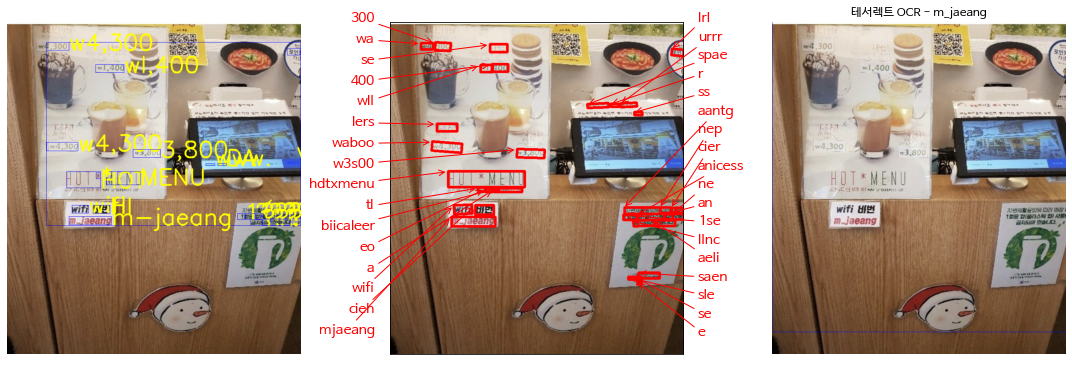

구글OCR: ['w4,300\n포인트\nwl,400\nw4,300\n3,800\nVAIN\nwww. DA\nHOT MENU\n*\nwifi HI\nm-jaeang\n1회용 컴(플라스터 킨 사용e\n금지되어 있습니다.\n', 'w4,300', '포인트', 'wl,400', 'w4,300', '3,800', 'VAIN', 'www.', 'DA', 'HOT', 'MENU', '*', 'wifi', 'HI', 'm-jaeang', '1', '회용', '컴', '(', '플라스터', '킨', '사용', 'e', '금지', '되어', '있습니다', '.'] /테서렉트OCR: ['']


In [26]:
display_img(full_paths[2],full_real[2], fontsize=2)

- 옆면에서 찍은 이미지: 옆면에서 찍어서 글씨가 약간 왜곡되어보이는 이미지

Done


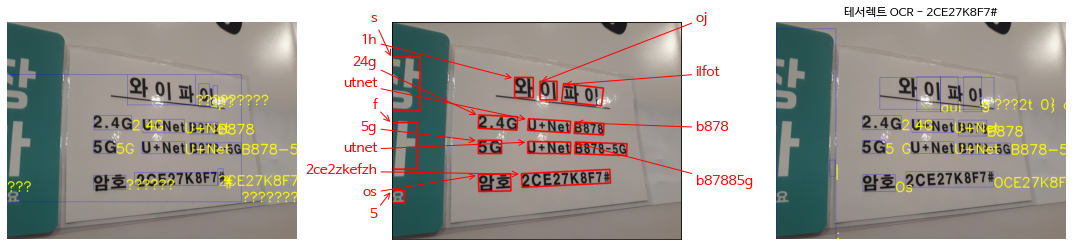

구글OCR: ['와이파아,\n2.4G U+Net B878\n5G\nU+Net B878-5G\n암호 2CE27K8F7#\n여\n', '와이파', '아', ',', '2.4G', 'U+Net', 'B878', '5G', 'U+Net', 'B878-5G', '암호', '2CE27K8F7', '#', '여'] /테서렉트OCR: ['—2t 0} a oy', 'au', 'i', '9', '2.4G', 'U+Net', 'B878', '5 G', 'U+Net', 'B878-5G', '|', 'Os', 'OCE27K8F/#', ';']


In [27]:
display_img(side_paths[0],side_real[0], fontsize=2)

### 문제점
- 내가 원하는 것은 와이파이 비밀번호만 가져오고 싶은데, 내가 원하지 않는 문자의 정보도 함께 들어온다. 이렇게 되면 내가 원하는 와이파이 비밀번호만 가져와서 살피는 것이 매우 힘들 것으로 생각된다.
- 그래서 __핸드폰으로 와이파이 비밀번호 안내문을 사진으로 찍을때 와이파이 비밀번호를 제외한 부분을 반투명하게 만들어서 인식되는 부분을 제외한 것은 어둡게 처리__ 한다. 그렇게 사진을 찍을때 애초에 __비밀번호만 딱 가져오고 그 외의 부분을 검은색으로 검은색으로 덮어서 내가 원하는 정보만 아래의 오른쪽__ 그림처럼 만들면 좀더 깔끔하게 이미지에서 __내가 원하는 와이파이 비밀번호만 가져오는 것이 좋을 것 같다__.

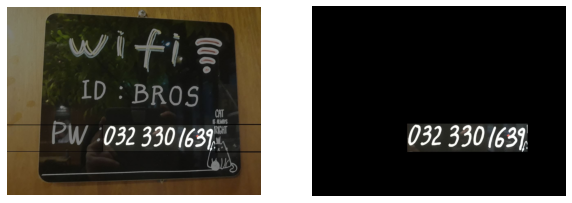

In [19]:
p=os.getenv('HOME')+'/aiffel/ocr_python/crop_img.JPG'
l=os.getenv('HOME')+'/aiffel/ocr_python/crop/front_001.JPG'
plt.figure(figsize=(10,5))
im=cv2.imread(p)
im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_=cv2.imread(l)
im_=cv2.cvtColor(im_, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(im_)
plt.axis("off")

plt.show()

In [28]:
front_paths = [i.replace("img","crop").replace("jpg","JPG") for i in front_paths]
full_paths =  [i.replace("img","crop").replace("jpg","JPG") for i in full_paths]
side_paths=  [i.replace("img","crop").replace("jpg","JPG") for i in side_paths]

이미지의 정답

In [63]:
side_real=["2CE27K8F7#", "0123456789","0323301639","youthzone2030"]
full_real=["rmaqnddj5", "123456789a","m_jaeang","0322201639","HOLLYS12345"]
front_real=["12345678!","02740390GA","032 330 1639","iloveyou22","abc12345",
           "061D5D71M#","since1996","HOLLYS12345","2CE27K8F7#","12345678"]

### 정면 이미지 테스트 10장

Done


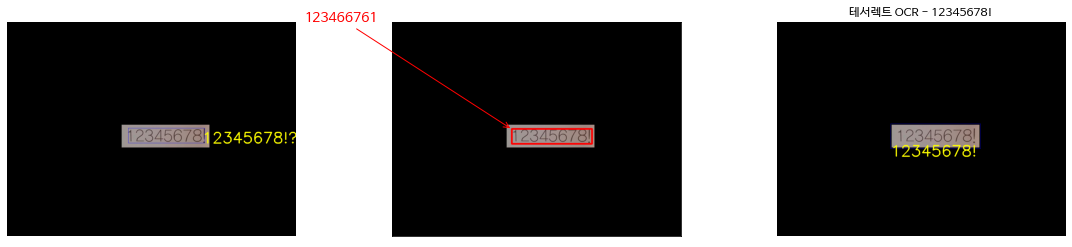

구글OCR: ['12345678!\n', '12345678!'] /테서렉트OCR: ['12345678!'] / 이미지 사이즈: (850, 1142, 3)


In [60]:
n=0
display_img(front_paths[n],front_real[n], fontsize=2)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 컴퓨터 프린트 출력, 전체 이미지 사이즈(850,1142)
- 첫번째 이미지는 가운데 케라스 OCR을 제외하고 모두 제대로 문자를 인식했다.
- 케라스의 경우 1234까지만 맞추었고 나머지는 틀렸다.

Done


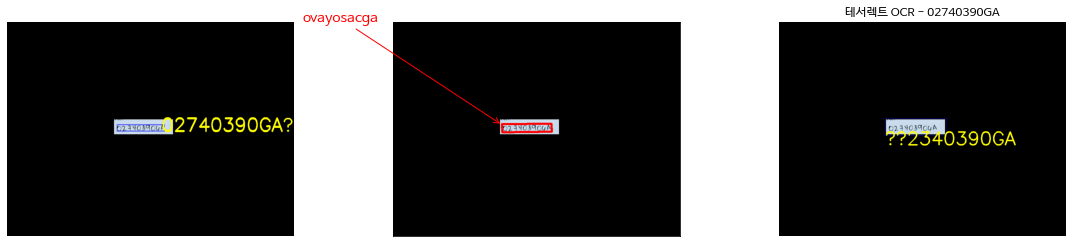

구글OCR: ['02740390GA\n', '02740390GA'] /테서렉트OCR: ['©2340390GA'] / 이미지 사이즈: (706, 944, 3)


In [64]:
n=1
display_img(front_paths[n],front_real[n], fontsize=2)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 손글씨, (706,944)
- 구글 OCR을 전부 맞았고, 케라스는 숫자 전체를 틀렸고, 테서렉트는 숫자일부(2개)를 틀렸다.


Done


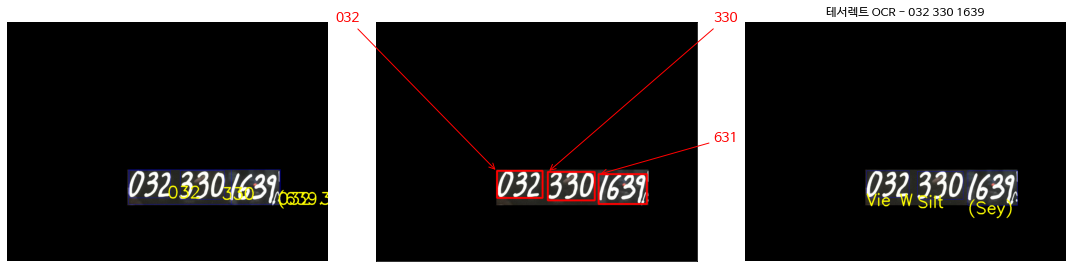

구글OCR: ['032 330 (639.\n', '032', '330', '(639.'] /테서렉트OCR: ['Vie W', 'Silt', '(Sey)'] / 이미지 사이즈: (869, 1163, 3)


In [62]:
n=2
display_img(front_paths[n],front_real[n], fontsize=2)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 손글씨, (869,1163)
- 각각 일부 틀렸다. 구글 OCR의 경우는 1을 (로 인식을 했고, 케라스는 1을 인식하지 못했고, 9는 1로 인식을 했다. 테서렉트는 숫자를 아예 영어로 인식했다.

Done


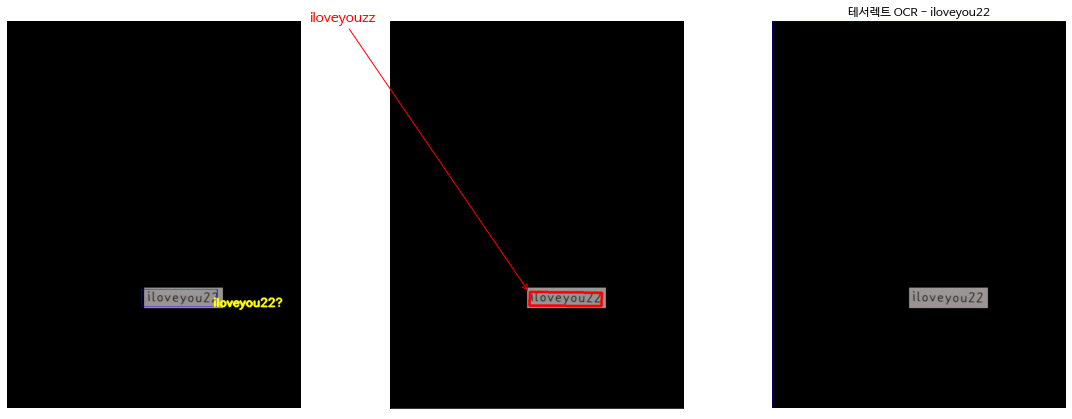

구글OCR: ['iloveyou22\n', 'iloveyou22'] /테서렉트OCR: [''] / 이미지 사이즈: (1019, 772, 3)


In [66]:
n=3
display_img(front_paths[n],front_real[n], fontsize=1)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 컴퓨터 출력 글씨, (869,1163)
- 구글의 경우 정확하게 인식했고, 케라스의 경우는 2를 z로 인식을 했다.(2개 틀림) 반면에 테서렉트는 아예 인식을 하지 못한 것으로 보인다.

Done


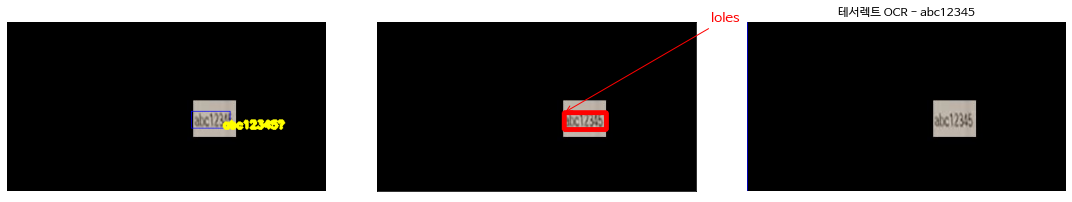

구글OCR: ['abc12345\n', 'abc12345'] /테서렉트OCR: ['ca'] / 이미지 사이즈: (242, 454, 3)


In [77]:
n=4
display_img(front_paths[n],front_real[n], fontsize=0.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 영수증 출력 (242,454)
- 구글 이미지는 정확하게 인식했고, 케라스는 전혀 다르게 인식, 테서렉트는 ca라고 인식을 했다. 즉 틀렸다.

Done


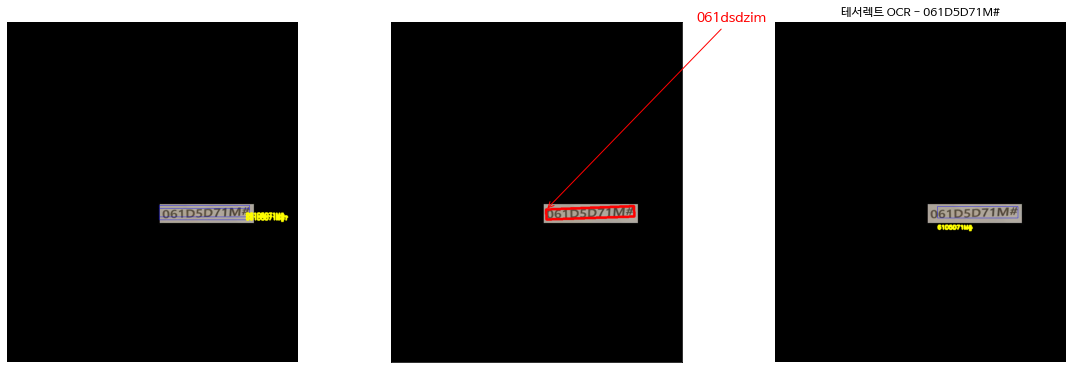

구글OCR: ['061D5D71M#\n', '061D5D71M#'] /테서렉트OCR: ['61D5D71M#'] / 이미지 사이즈: (920, 785, 3)


In [76]:
n=5
display_img(front_paths[n],front_real[n], fontsize=0.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (920,785)
- 구글 이미지는 정확하게 인식했고, 케라스는 5를 s로 /7을 z로/1을 i 로 잘못 인식했다, 테서렉트는 맨 앞의 0을 글자로 인식하지 않아서 0을 제외한 다른 글자는 잘 인식했다.

Done


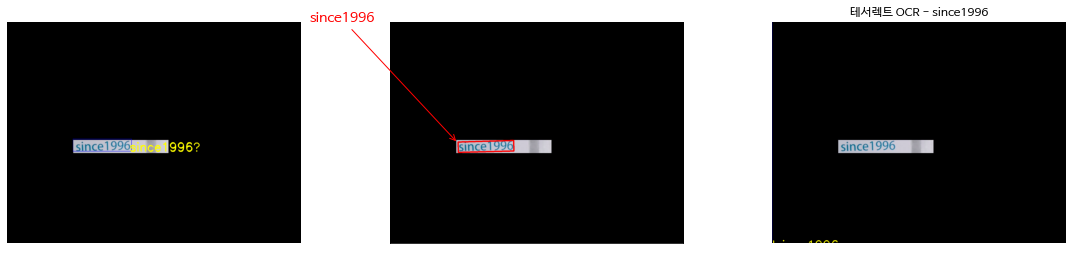

구글OCR: ['since1996\n', 'since1996'] /테서렉트OCR: ['lsince1996_'] / 이미지 사이즈: (1116, 1482, 3)


In [69]:
n=6
display_img(front_paths[n],front_real[n], fontsize=2)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (1116,1482)
- 구글과 케라스는 정확하게 인식했고, 테서렉트는 앞에 l을 뒤에 언더바_를 더 넣었다.

Done


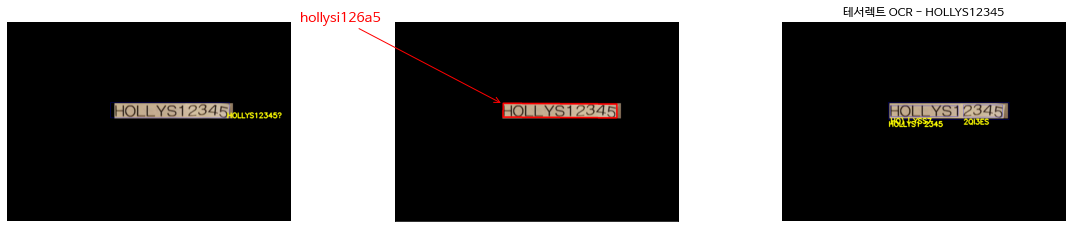

구글OCR: ['HOLLYS12345\n', 'HOLLYS12345'] /테서렉트OCR: ['HOLLYS1 2345', 'HO) | YSS7', '2QI3ES'] / 이미지 사이즈: (854, 1213, 3)


In [75]:
n=7
display_img(front_paths[n],front_real[n], fontsize=1)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력, 글자의 일부가 휘어져있다. (854, 1213)
- 구글 이미지는 정확하게 인식했고, 케라스는 holly와 12는 맞았지만 중간에 휘어진 3,4부분을 다르게 인식했다.반면 테서렉트는 처음 예측은 정확하지만 두번째 예측은 틀렸다. 아마도 휘어진 부분을 인식을 잘못하는 것 같다.

Done


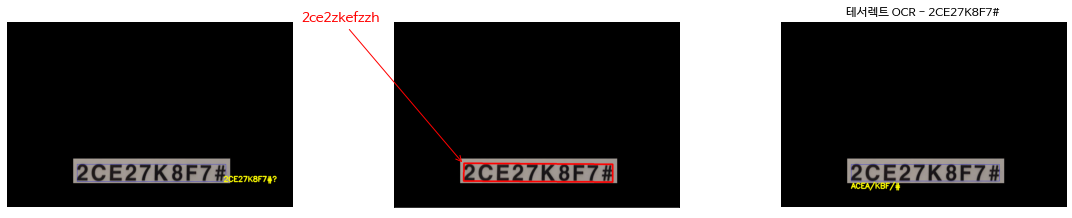

구글OCR: ['2CE27K8F7#\n', '2CE27K8F7#'] /테서렉트OCR: ['ACEA/KBF/#'] / 이미지 사이즈: (764, 1175, 3)


In [72]:
n=8
display_img(front_paths[n],front_real[n], fontsize=1)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (764,1175)
- 구글 이미지는 정확하게 인식했고, 케라스는 7을 z로 8을 e로 F7을 zz로 #을 h로 오인식했다. 테서렉트는 일부 몇글자만 맞고 나머지는 틀렸다.

Done


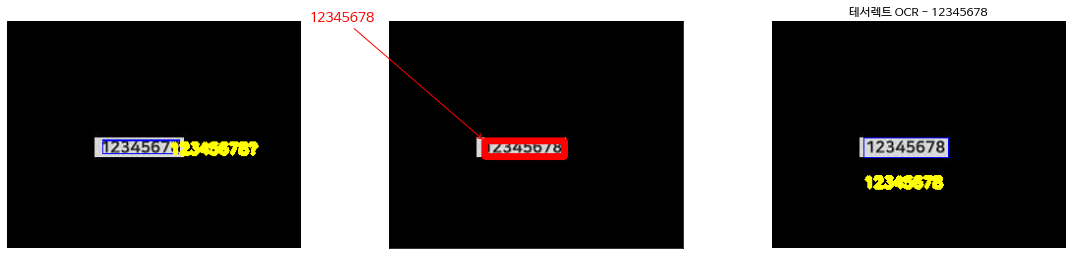

구글OCR: ['12345678\n', '12345678'] /테서렉트OCR: ['12345678'] / 이미지 사이즈: (231, 299, 3)


In [74]:
n=9
display_img(front_paths[n],front_real[n], fontsize=0.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (231,299)
- 모두 정확하게 출력했다.

## 옆면 이미지

Done


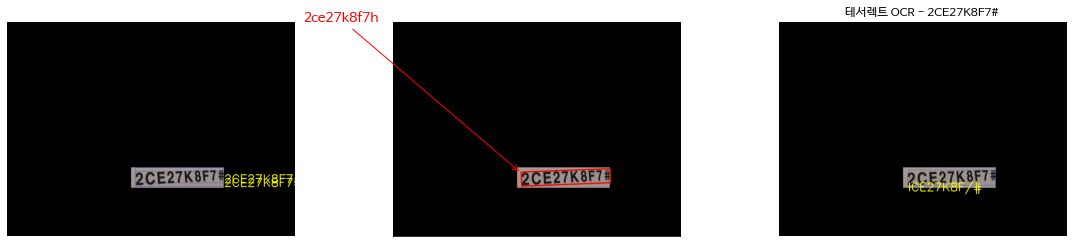

구글OCR: ['2CE27K8F7#\n', '2CE27K8F7#'] /테서렉트OCR: ['ICE27K8F/#'] / 이미지 사이즈: (1111, 1488, 3)


In [79]:
n=0
display_img(side_paths[n],side_real[n], fontsize=2)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (1111,1488)
- 구글은 완벽하게 맞추었고, 케라스는 #을 h로 오인식, 테서렉트는 2를 I로 7을 /로 오인식했다.

Done


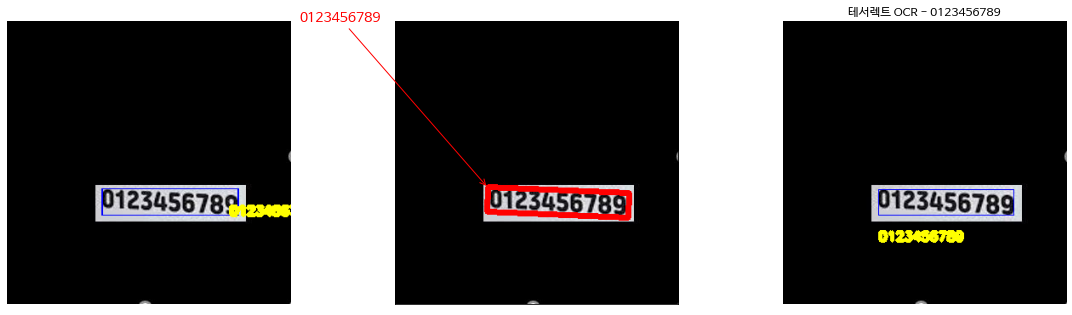

구글OCR: ['0123456789\n', '0123456789'] /테서렉트OCR: ['0123456789'] / 이미지 사이즈: (334, 334, 3)


In [82]:
n=1
display_img(side_paths[n],side_real[n], fontsize=0.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (334,334)
- 모두 정확하게 맞췄다.

Done


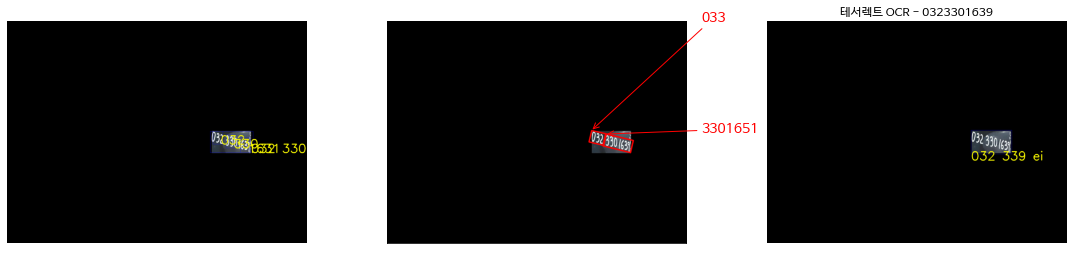

구글OCR: ['032 330 1631\n', '032', '330', '1631'] /테서렉트OCR: ['032 339 ei'] / 이미지 사이즈: (1097, 1478, 3)


In [83]:
n=2
display_img(side_paths[n],side_real[n], fontsize=2)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (1097,1478)
- 구글은 역시 정확하게 맞췄고 케라스의 경우는 2를 3으로 3을 5로 오인식하였다. 테서렉트는 6번째 글자 이후로 다 틀렸다

Done


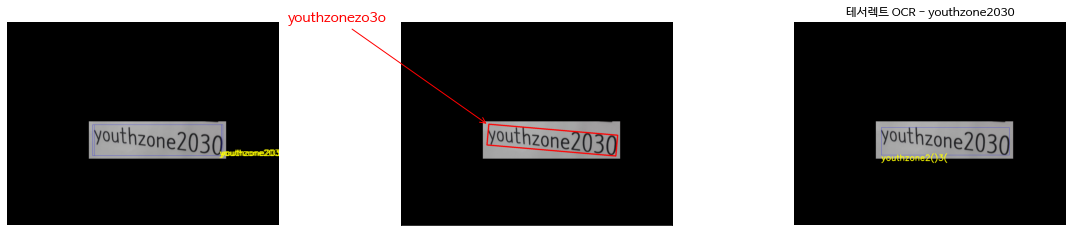

구글OCR: ['youthzone2030\n', 'youthzone2030'] /테서렉트OCR: ['youthzone2()3('] / 이미지 사이즈: (1110, 1482, 3)


In [85]:
n=3
display_img(side_paths[n],side_real[n], fontsize=1.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (1110,1482)
- 구글은 완벽하게 맞추었고, 케라스는 2을 z로/ 0을 o으로 오인식, 테서렉트는 0을 () 로 오인식했다.

## 배경을 많이 포함한 이미지

Done


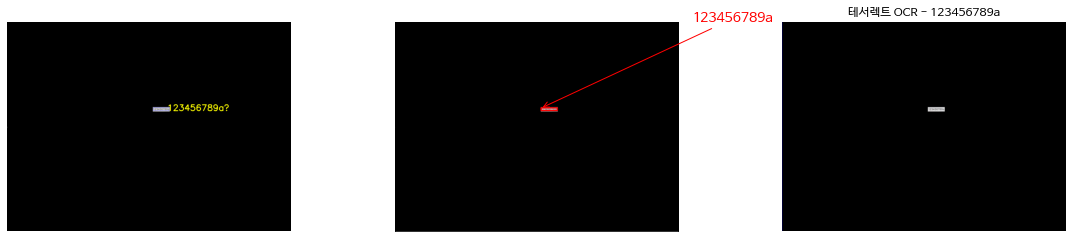

구글OCR: ['123456789a\n', '123456789a'] /테서렉트OCR: [''] / 이미지 사이즈: (1104, 1492, 3)


In [87]:
n=1
display_img(full_paths[n],full_real[n], fontsize=1.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (1104,1492)
- 구글 케라스 정확하게 인식했다. 반면 테서렉트는 문자를 인식하지 못했다.

Done


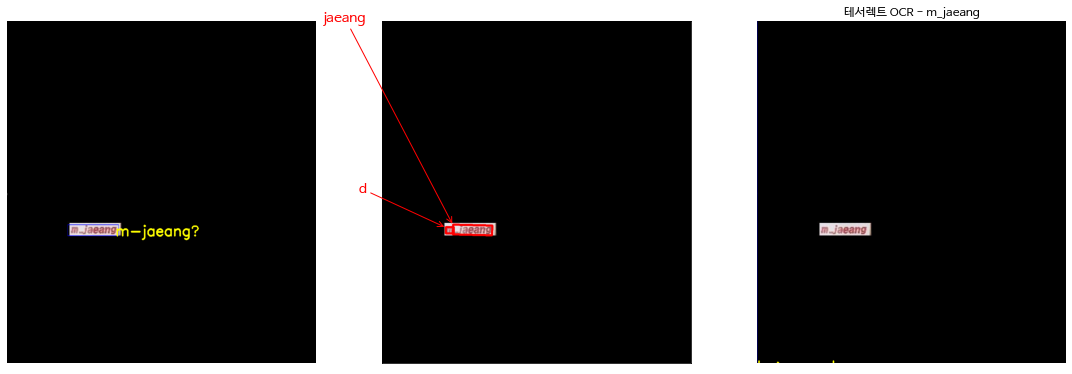

구글OCR: ['m-jaeang\n', 'm-jaeang'] /테서렉트OCR: ['|mjaeang |'] / 이미지 사이즈: (1092, 984, 3)


In [88]:
n=2
display_img(full_paths[n],full_real[n], fontsize=1.5)

왼쪽: 구글 OCR/ 가운데: 케라스 OCR/ 오른쪽: 테서렉트 OCR
- 이미지 특징: 프린터 출력 (1092,984)
- 구글은 언더바_ 를 그냥 바(bar, -)로 오인식했고, 케라스는 첫글자 m을 d로 오인식하고 언더바_를 인식 못했다.반면 테서렉트는 문자를 인식하지 못했다.

Done


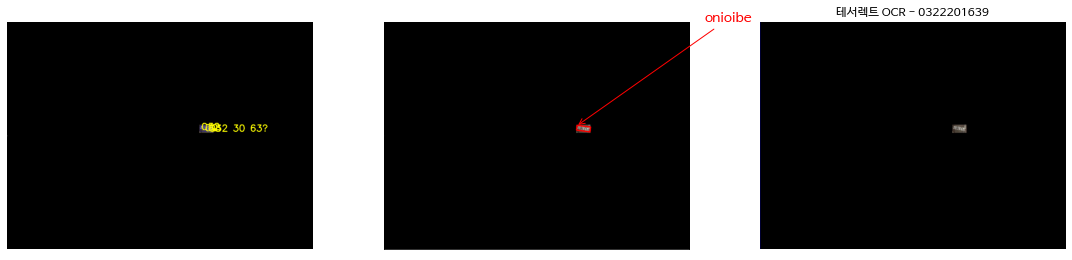

구글OCR: ['032 30 63\n', '032', '30', '63'] /테서렉트OCR: [''] / 이미지 사이즈: (1111, 1494, 3)


In [89]:
n=3
display_img(full_paths[n],full_real[n], fontsize=1.5)

글씨 이미지가 너무 잘 안보여서 아래의 이미지가 원본임을 밝힌다. 
- 구글 OCR은 032는 완전하게 맞췄고 뒤의 글자는 30과 63은 인식이 잘 되었지만, 나머지는 인식이 안되었다. 
- 케라스는 숫자를 전부 알파벳으로 인식했다.
- 테서렉트의 경우는 아예 인식이 되지 않았다.

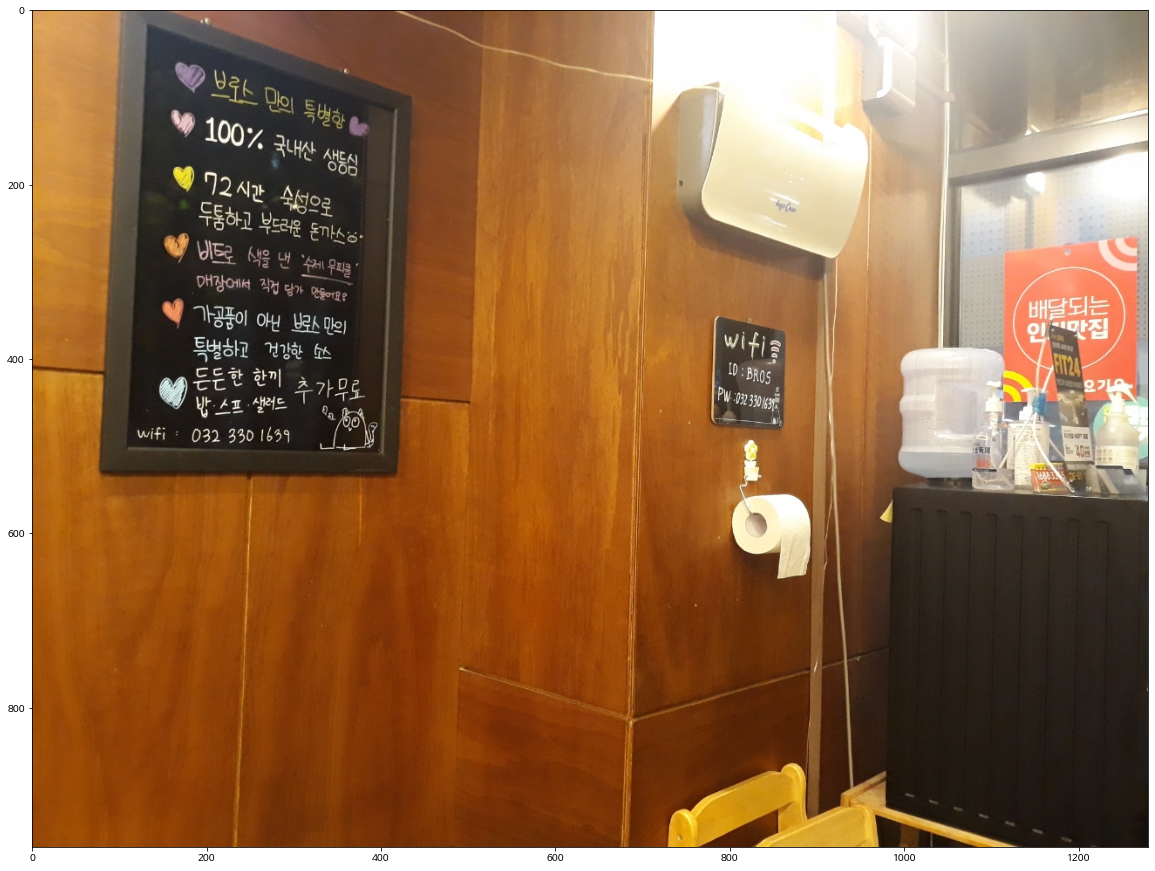

In [95]:
plt.figure(figsize=(20,25))
m=cv2.imread(full_paths[n].replace("JPG","jpg").replace("crop","img"))
m=cv2.cvtColor(m, cv2.COLOR_BGR2RGB)
plt.imshow(m)
plt.show()

## 정리
- 가장 성능이 좋은 것은 구글 비전의 유료 API인 OCR이 성능이 좋았다.오인식이 되는 글자가 몇개 있었을뿐 대부분의 글자를 정확하게 인식해냈다.
- 반면 케라스 OCR과 테서렉트의 경우는 상황에 따라서 오인식이 되는 경우가 조금씩 달랐다.
- 케라스 OCR은 숫자와 특수문자를 알파벳으로 오인식하는 경우가 많았다. 특히 #을 h로 오인식했다. 아예 숫자로만 이뤄진 경우에는 한두개 정도 틀려서 오인식이 적은편인데 숫자와 영어가 섞여있는 이미지의 경우 7을 z로 #을 h로 오인식하는 경우가 많았다.
- 반면 테서렉트는 전체 이미지 사이즈에 비해서 인식하려고 하는 문자가 차지하는 크기가 작은 경우에는 인식을 아예 하지 않는 것을 볼수 있었다. 케라스는 일부라도 맞은 답 혹은 아예 틀린 답이라도 가져오는 반면 테서렉트는 아마도 너무 틀린다 싶으면 출력하지 않는 것 같다. 
- 아래 케이스는 테서렉트를 제외하고 케라스와 구글OCR모두 성능이 좋았다. 이미지가 너무 작아서 인식이 안되는 것일수도 있고, 아니면 이 글씨체가 생소해서 글씨를 못 찾아내을 수도 있겠다는 생각이 들었다. 아래 케이스에서도 가운데 이미지 keras OCR은 2를 z로 오인식했다.

Done


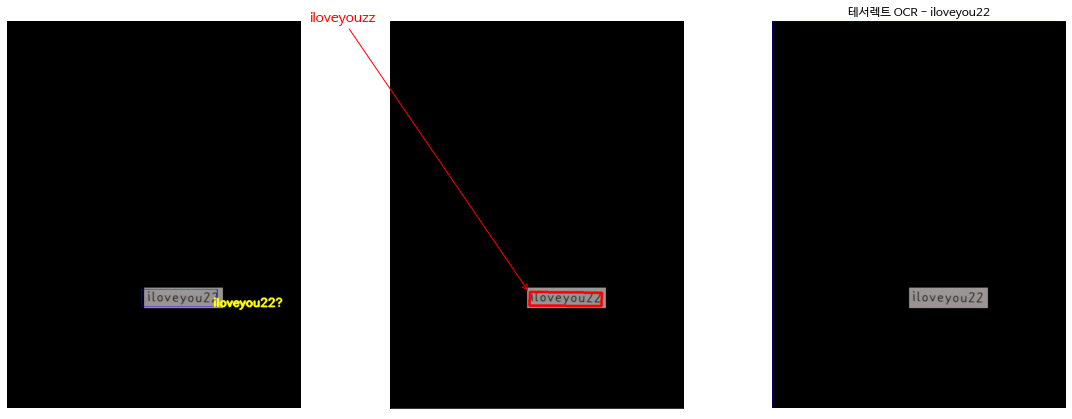

구글OCR: ['iloveyou22\n', 'iloveyou22'] /테서렉트OCR: [''] / 이미지 사이즈: (1019, 772, 3)


In [96]:
n=3
display_img(front_paths[n],front_real[n], fontsize=1)

Done


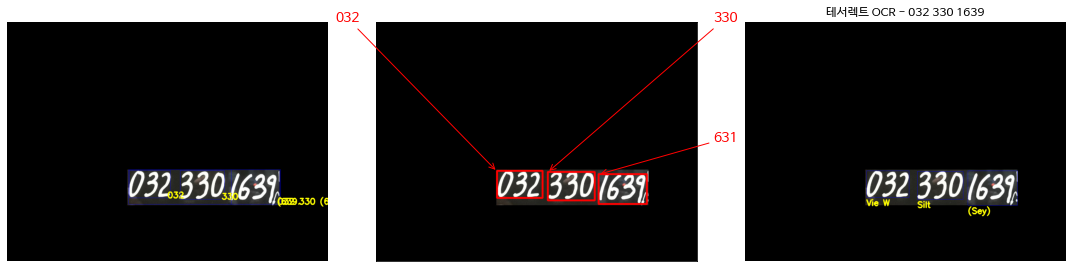

구글OCR: ['032 330 (639.\n', '032', '330', '(639.'] /테서렉트OCR: ['Vie W', 'Silt', '(Sey)'] / 이미지 사이즈: (869, 1163, 3)


In [99]:
n=2
display_img(front_paths[n],front_real[n], fontsize=1)

테서렉트가 글씨체가 좀 특이한 경우 인식율이 낮아진다고 생각이 들었던 이미지이다.   
위의 이미지는 __손글씨로 비밀번호를 입력__ 한 경우이다. 구글 OCR과 케라스 OCR은 글씨를 일부 틀렸다면 __테서렉트 OCR의 경우는 숫자를 글자로 인식해서 처음부터 끝까지 오인식__ 을 했다. 위의 iloveyou22 이미지의 경우 컴퓨터 출력을 한 글씨체이지만 흔히 사용하는 고딕체 같이 흔한 글씨체가 아니었고, (032 330 1639) 이미지는 손글씨를 오인식 한 것을 보아서 테서렉트 OCR은 다양한 글씨체를 가진 데이터에서는 학습이 되지 않았나 생각을 해보았다.

-------------------------------------------------------


Done


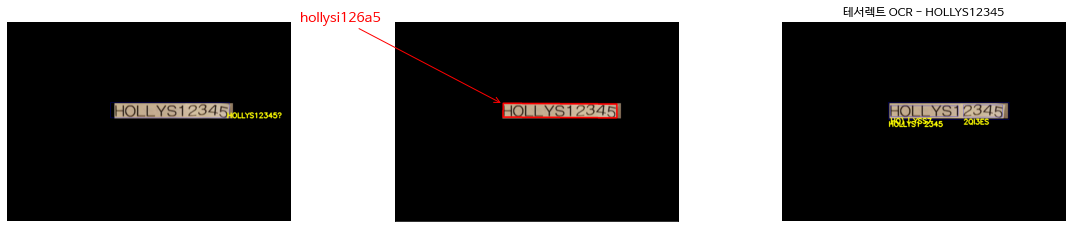

구글OCR: ['HOLLYS12345\n', 'HOLLYS12345'] /테서렉트OCR: ['HOLLYS1 2345', 'HO) | YSS7', '2QI3ES'] / 이미지 사이즈: (854, 1213, 3)


In [97]:
n=7
display_img(front_paths[n],front_real[n], fontsize=1)

- 바로 위의 이미지의 경우는 2345부분이 약간 휘어진 이미지이다. 구글은 이렇게 글자가 쓰여진 표면이 곡면인 경우도 학습이 잘 된 것을 알수가 있다. 반면에 케라스는 글씨가 쓰여진 표면이 많이 휘어진 3,4를 완전히 다른 글자로 오인식 한 것을 보아서 평평한 표면에서 쓰여진 글씨 위주로 학습이 된 것이 아닐까 생각을 했다. 반면 테서렉트는 처음 예측한 HOLLY1 2345로 정확하게 인식을 한 것으로 보인다. 

## 회고
- 구글 비전의 OCR은 다양한 이미지에 대해서 정확하게 인식하는 것을 확인할 수 있었다. 다른 사람에게 배포를 하지 않고 개인 소장 앱을 만들 것 같으면 구글 OCR을 사용해서 와이파이 비밀번호 인식을 할것 같다. 아니면 개인적으로 구글 계정 키를 넣도록 만들어서 OCR을 인식하도록 만드는 앱을 만들 것 같다. 일년 동안 와이파이 비밀번호를 1000번 이상 인식시킬 일은 없을 것 같아서 같아서 말이다.
- 그렇지만 가급적이면 사람들에게 결제하는 부담을 들이지 않고 만드는 앱을 생각해본다면 테서렉트를 사용해서 와이파이 비밀번호 입력 앱을 만들 것 같다. 
- 사람들이 와이파이 비밀번호를 입력할때 그래도 최소한 비밀번호 있는 곳 근처로 간다던지 줌을 당겨서 사진을 찍어서 사진 한가운데 비밀번호가 크게 오게해서 사진찍는 것을 생각한다면 글씨가 작아서 성능이 떨어지는  숫자를 알파벳으로 오인식하는 케라스 OCR보다는 테서렉트 OCR이 좀 더 유용할 것으로 생각이 된다. 다만 테서렉트가 다양한 다양한 글씨체에서 좋은 성능을 보이는 것은 아닌 것 같아보여서 아쉬운 생각이 들었다. 
- 지금까지는 기계학습 혹은 인공지능 기술을 어떻게 결과를 내고 성능이 내는지에 대해서 집중하면서 과제를 하다가 실제로 상용프로그램이 된다고 생각을 하고 모델을 테스트하면서 들었던 생각이 이 모델을 사용하는데 API 사용비용도 생각하게 되었다.
- 정말 제한된 와이파이 비밀번호 입력이라는 간단한 업무에 있어서도 테스트 이미지의 글씨체와 글씨가 이미지 대비 얼마나 크기를 차지하느냐에 따라서 인식률이 달라지는 것을 보면서 실제로 데이터를 수집하고 모델을 만드는 과정에서 생겨나는 문제들을 어떻게 보완하느냐가 중요한 일이 되겠다는 생각이 들었다. 예를들어 기존 모델이 테서렉트 OCR이 다양한 글씨체에 대해서는 성능이 안나오면 더 많은 글씨체의 문자 데이터를 학습데이터에 추가하는 일이 필요하겠다는 생각을 했다.